# Time Series Modeling

In [1]:
# import libraries
import os
import sys
import urllib.request
import json
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
!pip install pytrends
from pytrends.request import TrendReq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16127 sha256=12e99ff003e592e4a13943373163ccd0d637f174125bf4f348debccce8c19495
  Stored in directory: /root/.cache/pip/wheels/e8/78/c8/18d4f4804753e14416809b365773220c48b41fe5387f2bb6b9
Successfully built pytrends


## 1. Importing Data & Cleaning

* Google Trends
* Count of articles in five newspapers over time
* Covid-19 data
* Hyundai EV, HEV, and PHEV sales data

### 1-1. Google Trends

In [2]:
# google trends

pytrends = TrendReq(hl='ko', tz=540)

kw_list = ["전기차", "친환경", "전기차 보조금", "전기차 가격"]

pytrends.build_payload(kw_list, cat=0, timeframe="2018-01-01 2022-11-01", geo="KR")
google = pytrends.interest_over_time()
google = google.reset_index()
google['date'] = pd.to_datetime(google['date'])

In [3]:
fig = px.line(google, x="date", y=kw_list,
              title="Google Trends in South Korea",
             labels={
                 "variable" : "Search Term", "date" : "Time", "value" : "Popularity"
             }, template = 'simple_white')

fig.show()

### 1-2. Naver News Articles

In [4]:
# number of articles on EVs

news = pd.read_csv("/content/articles_ev.csv")
news['date'] = pd.to_datetime(news['date'])

tot_count = news.iloc[:, 1:5]
news['total'] = tot_count.sum(axis=1)

### 1-3. Covid-19 Data

In [5]:
covid = pd.read_csv("/content/covid_data.csv", encoding= 'unicode_escape')
covid = covid.iloc[:, [0,1,2,6,11,12,15]]
covid.columns = ['date', 'seoul_pat', 'seoul_new', 'seoul_death', 'nat_pat', 'nat_new', 'nat_death']
covid['date'] = pd.to_datetime(covid['date'])

### 1-4. Hyundai EV, HEV, PHEV Sales Data

In [6]:
hyundai = pd.read_csv('/content/hyundai.csv')
hyundai = hyundai.fillna(0)
hyundai['date'] = pd.to_datetime(hyundai['date'])

# sum of domestic ev sales

ev_d = hyundai.loc[:, ['ioniq_ev_d','g80_ev_d','kona_ev_d','gv70_ev_d']]
hyundai['ev_d'] = ev_d.sum(axis = 1)

# sum of ev export sales

ev_e = hyundai.loc[:, ['ioniq_ev_e','g80_ev_e','kona_ev_e','gv70_ev_e']]
hyundai['ev_e'] = ev_e.sum(axis = 1)

# sum of all ev sales

ev = hyundai.loc[:, ['ioniq_ev_d','g80_ev_d','kona_ev_d','gv70_ev_d','ioniq_ev_e','g80_ev_e','kona_ev_e','gv70_ev_e']]
hyundai['ev'] = ev.sum(axis = 1)

# sum of domestic hev sales

hev_d = hyundai.loc[:, ['avante_hev_d','ioniq_hev_d','sonata_hev_d','sonata_dn8_hev_d','grandeur_hev_d',
                  'kona_hev_d','tuscon_hev_d','santa_hev_d']]
hyundai['hev_d'] = hev_d.sum(axis = 1)

# sum of hev export sales

hev_e = hyundai.loc[:, ['avante_hev_e','ioniq_hev_e','sonata_hev_e','sonata_dn8_hev_e','grandeur_hev_e',
                 'kona_hev_e','tuscon_hev_e','santa_hev_e']]
hyundai['hev_e'] = hev_e.sum(axis = 1)

# sum of all hev sales

hev = hyundai.loc[:, ['avante_hev_d','ioniq_hev_d','sonata_hev_d','sonata_dn8_hev_d','grandeur_hev_d',
                  'kona_hev_d','tuscon_hev_d','santa_hev_d','avante_hev_e','ioniq_hev_e','sonata_hev_e','sonata_dn8_hev_e','grandeur_hev_e',
                 'kona_hev_e','tuscon_hev_e','santa_hev_e']]
hyundai['hev'] = hev.sum(axis = 1)

# total sales for ev, hev, phev

cols = hyundai.iloc[:, 0:31]
hyundai['total'] = cols.sum(axis = 1)

<ipython-input-6-022ee30333f3>:42: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



## 2. Simple OLS

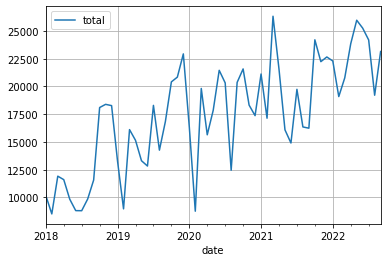

In [7]:
# trendline

hyundai.plot(x = 'date', y = 'total', grid = True)

### 2-1. Autocorrelation

In [8]:
# autocorrelation

n_auto = news['total'].autocorr()
h_auto= hyundai['total'].autocorr()
c_auto = covid['nat_new'].autocorr()
print(n_auto, h_auto, c_auto)

0.888533272769404 0.6350798885850865 0.9513640701107877


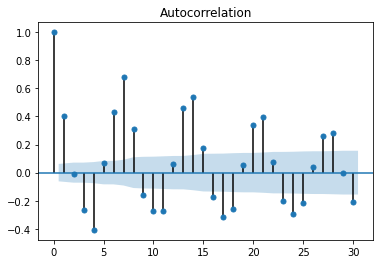

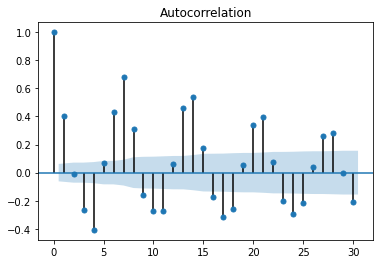

In [9]:
# Autocorrelation Function Covid-19

Ca = covid['nat_new'].diff(4) # seasonal difference
Ca = Ca.dropna()
plot_acf(Ca)

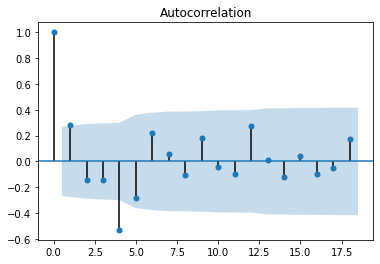

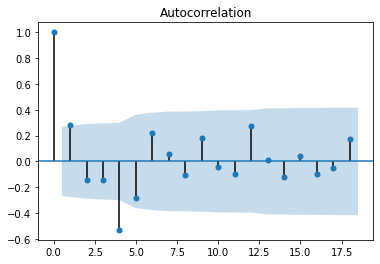

In [10]:
# Autocorrelation Function Hyundai sales

HDa = hyundai['total'].diff(4)
HDa = HDa.dropna()
plot_acf(HDa)

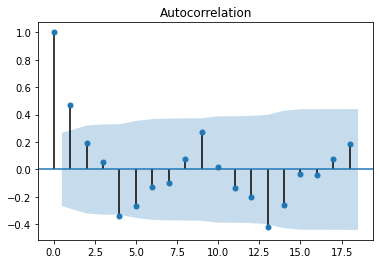

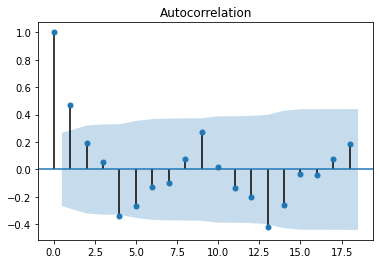

In [11]:
# Autocorrelation Function News Articles

NWa = news['total'].diff(4)
NWa = NWa.dropna()
plot_acf(NWa)

### 2-2. Correlation between number of news articles and Hyundai car sales

0.34789443162967015


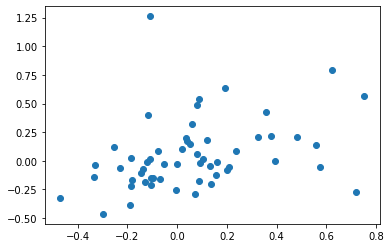

In [12]:
# Correlation of two time series

news.drop(news.tail(1).index,inplace=True)

news['tot_pct'] = news['total'].pct_change()

hyundai['evhev_pct'] = hyundai['total'].pct_change()

nh_corr = (news['tot_pct']).corr(hyundai['evhev_pct'])
print(nh_corr)

plt.scatter(news['tot_pct'], hyundai['evhev_pct'])
plt.show()

In [13]:
news_pct = news['tot_pct']
hyundai_pct = hyundai['evhev_pct']
news_hyun = news.merge(hyundai, on='date', how='left')
news_hyun = news_hyun.dropna()

In [14]:
news_hyun = sm.add_constant(news_hyun)

nh_reg = sm.OLS(news_hyun['tot_pct'],news_hyun[['const','evhev_pct']]).fit()
print(nh_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                tot_pct   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     7.436
Date:                Tue, 20 Dec 2022   Prob (F-statistic):            0.00861
Time:                        22:08:18   Log-Likelihood:                -1.5429
No. Observations:                  56   AIC:                             7.086
Df Residuals:                      54   BIC:                             11.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0459      0.034      1.337      0.1

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



### 2-3. Correlation between number of Covid-19 and news articles

In [15]:
covid_m = pd.read_csv("/content/covid_m.csv", encoding= 'unicode_escape')
covid_m['date'] = pd.to_datetime(covid_m['date'])
covid_m = covid_m.iloc[:32]

news_c = news.iloc[25:57]

<ipython-input-16-bca6e07611a6>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



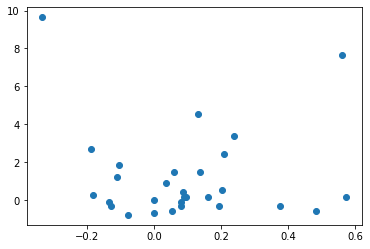

0.11537042044094724


In [16]:
# Correlation of two time series

news_c['tot_pct'] = news_c['total'].pct_change()

covid_m['nat_pct'] = covid_m['nat_new'].pct_change()

plt.scatter(news_c['tot_pct'], covid_m['nat_pct'])
plt.show()

newsandcovcorr = news_c['tot_pct'].corr(covid_m['nat_pct'])
print(newsandcovcorr)

In [17]:
news_cpct = news_c['tot_pct']
covid_pct = covid_m['nat_pct']
news_cov = news_c.merge(covid_m, on='date', how='left')
news_cov = news_cov.dropna()
news_cov = news_cov.iloc[1:]

In [18]:
news_cov = sm.add_constant(news_cov)

nc_reg = sm.OLS(news_cov['tot_pct'],news_cov[['const','nat_pct']]).fit()
print(nc_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                tot_pct   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                   0.08834
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.769
Time:                        22:08:19   Log-Likelihood:                 3.6850
No. Observations:                  29   AIC:                            -3.370
Df Residuals:                      27   BIC:                           -0.6355
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0945      0.046      2.061      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



### 2-4. Correlation between Covid-19 cases and Hyundai sales

In [19]:
hyundai_c = hyundai.iloc[25:57]

<ipython-input-20-10dc7d8d225b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



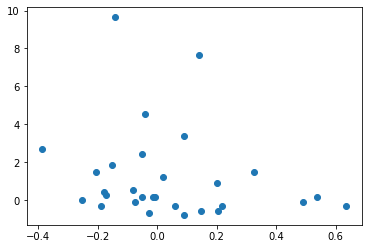

0.11537042044094724


In [20]:
# Correlation of two time series

hyundai_c['evhev_pct'] = hyundai_c['total'].pct_change()

plt.scatter(hyundai_c['evhev_pct'], covid_m['nat_pct'])
plt.show()

carandcovcorr = hyundai_c['evhev_pct'].corr(covid_m['nat_pct'])
print(newsandcovcorr)

In [21]:
covid_pct = covid_m['nat_pct']
hyundai_pct = hyundai_c['evhev_pct']
car_cov = hyundai_c.merge(covid_m, on='date', how='left')
car_cov = car_cov.dropna()
car_cov = car_cov.iloc[1:]

In [22]:
car_cov = sm.add_constant(car_cov)

nc_reg = sm.OLS(car_cov['evhev_pct'],car_cov[['const','nat_pct']]).fit()
print(nc_reg.summary())

                            OLS Regression Results                            
Dep. Variable:              evhev_pct   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.085
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.307
Time:                        22:08:19   Log-Likelihood:                 1.4059
No. Observations:                  29   AIC:                             1.188
Df Residuals:                      27   BIC:                             3.923
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0617      0.050      1.244      0.2

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



## 3. ARIMA forecasting

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict

### 3-1. News (entire study period)

In [24]:
news_total = news.iloc[:, [0, 6]]

In [25]:
news_dummies = pd.get_dummies(news_total, columns=['date'], drop_first=True)

* parameter (1, 0, 0)

In [26]:
# Split data into train / test sets
train = news_dummies.iloc[:len(news_dummies)-12]
test = news_dummies.iloc[len(news_dummies)-12:] # set one year(12 months) for testing

model = SARIMAX(train['total'], 
                order = (1, 0, 0))
  
result = model.fit()
result.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   45
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -235.710
Date:                Tue, 20 Dec 2022   AIC                            475.421
Time:                        22:08:20   BIC                            479.034
Sample:                             0   HQIC                           476.768
                                 - 45                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9813      0.027     36.063      0.000       0.928       1.035
sigma2      1929.3168    419.534      4.599      0.000    1107.046    2751.588
===================================================================================
Ljung-Box (L1) (Q):                  12.00   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.00   Prob(JB):                         0.98
Heteroskedasticity (H):               1.20   Skew:                             0.07
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



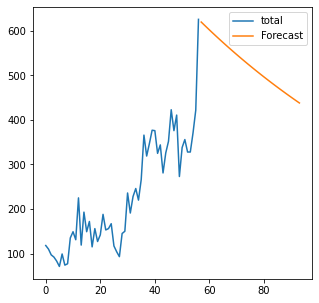

In [27]:
mod = SARIMAX(news_dummies['total'], order = (1,0,0))
res = mod.fit()

#forecast 3 years (to 2025)

forecast = res.predict(start = len(news_dummies), 
                          end = (len(news_dummies) + 3*12), 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
news_dummies['total'].plot(figsize = (5, 5), legend = True)
forecast.plot(legend = True)

* parameter (9, 0, 1)

In [28]:
# Split data into train / test sets
train = news_dummies.iloc[:len(news_dummies)-12]
test = news_dummies.iloc[len(news_dummies)-12:] # set one year(12 months) for testing

model = SARIMAX(train['total'], 
                order = (9, 0, 1))
  
result = model.fit()
result.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   45
Model:               SARIMAX(9, 0, 1)   Log Likelihood                -224.865
Date:                Tue, 20 Dec 2022   AIC                            471.730
Time:                        22:08:22   BIC                            491.603
Sample:                             0   HQIC                           479.138
                                 - 45                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3575      0.297     -1.206      0.228      -0.939       0.224
ar.L2          1.1808      0.236      4.994      0.000       0.717       1.644
ar.L3          0.6584      0.285      2.312      0.021       0.100       1.217
ar.L4         -0.3338      0.272     -1.226      0.220      -0.868       0.200
ar.L5         -0.5762      0.251     -2.294      0.022      -1.069      -0.084
ar.L6          0.1798      0.280      0.643      0.520      -0.368       0.728
ar.L7          0.4624      0.235      1.967      0.049       0.002       0.923
ar.L8         -0.0380      0.191     -0.198      0.843      -0.413       0.337
ar.L9         -0.1960      0.172     -1.138      0.255      -0.534       0.142
ma.L1          0.9746      0.664      1.468      0.142      -0.327       2.276
sigma2      1098.4703    657.538      1.671      0.095    -190.280    2387.221
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.93   Prob(JB):                         0.43
Heteroskedasticity (H):               1.58   Skew:                             0.43
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



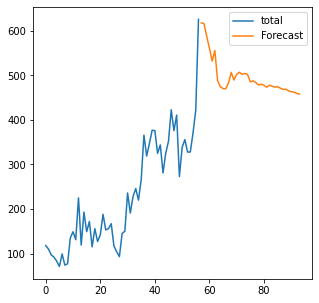

In [29]:
mod = SARIMAX(news_dummies['total'], order = (9,0,1))
res = mod.fit()

#forecast 3 years (to 2025)

forecast = res.predict(start = len(news_dummies), 
                          end = (len(news_dummies) + 3*12), 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
news_dummies['total'].plot(figsize = (5, 5), legend = True)
forecast.plot(legend = True)

### 3-2. News (pre-covid)

In [30]:
news_precov = news_total.iloc[0:25]

In [31]:
news_precov_dummies = pd.get_dummies(news_precov, columns=['date'], drop_first=True)

* parameter (1, 0, 0)

In [32]:
# Split data into train / test sets
train = news_precov_dummies.iloc[:len(news_precov_dummies)-12]
test = news_precov_dummies.iloc[len(news_precov_dummies)-12:] # set one year(12 months) for testing

model = SARIMAX(train['total'], 
                order = (1, 0, 0))
  
result = model.fit()
result.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   13
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -66.173
Date:                Tue, 20 Dec 2022   AIC                            136.345
Time:                        22:08:24   BIC                            137.475
Sample:                             0   HQIC                           136.113
                                 - 13                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9783      0.085     11.528      0.000       0.812       1.145
sigma2      1212.5627    451.565      2.685      0.007     327.511    2097.614
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                 4.66
Prob(Q):                              0.55   Prob(JB):                         0.10
Heteroskedasticity (H):              17.95   Skew:                             1.37
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

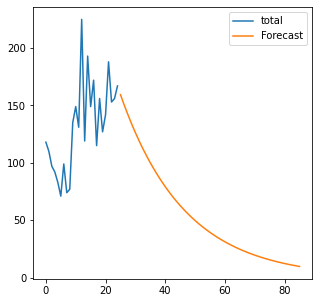

In [33]:
mod = SARIMAX(news_precov_dummies['total'], order = (1,0,0))
res = mod.fit()

#forecast 5 years (to 2025)

forecast = res.predict(start = len(news_precov_dummies), 
                          end = (len(news_precov_dummies) + 5*12), 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
news_precov_dummies['total'].plot(figsize = (5, 5), legend = True)
forecast.plot(legend = True)

* parameter (8, 0, 1)

In [34]:
# Split data into train / test sets
train = news_precov_dummies.iloc[:len(news_precov_dummies)-12]
test = news_precov_dummies.iloc[len(news_precov_dummies)-12:] # set one year(12 months) for testing

model = SARIMAX(train['total'], 
                order = (8, 0, 1))
  
result = model.fit()
result.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   13
Model:               SARIMAX(8, 0, 1)   Log Likelihood                 -59.598
Date:                Tue, 20 Dec 2022   AIC                            139.196
Time:                        22:08:26   BIC                            144.845
Sample:                             0   HQIC                           138.035
                                 - 13                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6754      0.201      3.364      0.001       0.282       1.069
ar.L2          0.1361      0.136      1.002      0.316      -0.130       0.402
ar.L3          1.3179      0.099     13.287      0.000       1.123       1.512
ar.L4          0.0208      0.155      0.134      0.893      -0.283       0.325
ar.L5         -1.3138      0.139     -9.483      0.000      -1.585      -1.042
ar.L6         -0.1211      0.210     -0.575      0.565      -0.534       0.291
ar.L7         -0.6793      0.160     -4.255      0.000      -0.992      -0.366
ar.L8          0.9608      0.117      8.182      0.000       0.731       1.191
ma.L1          0.8399      5.951      0.141      0.888     -10.823      12.503
sigma2        44.1075    308.127      0.143      0.886    -559.810     648.025
===================================================================================
Ljung-Box (L1) (Q):                   2.21   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.14   Prob(JB):                         0.54
Heteroskedasticity (H):              25.71   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         1.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



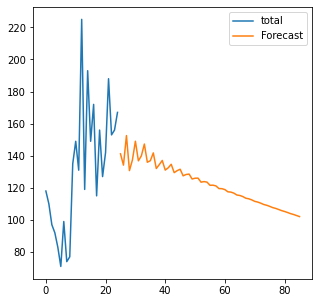

In [35]:
mod = SARIMAX(news_precov_dummies['total'], order = (8,0,1))
res = mod.fit()

#forecast 5 years (to 2025)

forecast = res.predict(start = len(news_precov_dummies), 
                          end = (len(news_precov_dummies) + 5*12), 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
news_precov_dummies['total'].plot(figsize = (5, 5), legend = True)
forecast.plot(legend = True)

### 3-3. Hyundai Car (entire study period)

In [36]:
car_total = hyundai.iloc[:, [0, 37]]

In [37]:
car_precovid = car_total.iloc[0:25]

In [38]:
car_dummies = pd.get_dummies(car_total, columns=['date'], drop_first=True)
car_precovid_dummies = pd.get_dummies(car_precovid, columns=['date'], drop_first=True)

* parameter (1, 0, 0)

In [39]:
# Split data into train / test sets
train = car_dummies.iloc[:len(car_dummies)-12]
test = car_dummies.iloc[len(car_dummies)-12:] # set one year(12 months) for testing

model = SARIMAX(train['total'], 
                order = (1, 0, 0))
  
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   45
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -441.708
Date:                Tue, 20 Dec 2022   AIC                            887.416
Time:                        22:08:28   BIC                            891.029
Sample:                             0   HQIC                           888.763
                                 - 45                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9609      0.040     23.920      0.000       0.882       1.040
sigma2      1.877e+07   1.44e-10    1.3e+17      0.000    1.88e+07    1.88e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.76   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.03   Prob(JB):                         0.56
Heteroskedasticity (H):               1.93   Skew:                             0.38
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.36e+32. Standard errors may be unstable.
"""

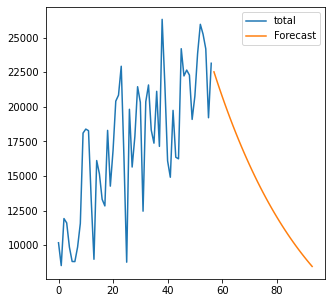

In [40]:
mod = SARIMAX(car_dummies['total'], order = (1,0,0))
res = mod.fit()

#forecast 3 years (to 2025)

forecast = res.predict(start = len(car_dummies), 
                          end = (len(car_dummies) + 3*12), 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
car_dummies['total'].plot(figsize = (5, 5), legend = True)
forecast.plot(legend = True)

* parameter (2, 2, 1)

In [41]:
# Split data into train / test sets
train = car_dummies.iloc[:len(car_dummies)-12]
test = car_dummies.iloc[len(car_dummies)-12:] # set one year(12 months) for testing

model = SARIMAX(train['total'], 
                order = (2, 2, 1))
  
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   45
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -419.933
Date:                Tue, 20 Dec 2022   AIC                            847.866
Time:                        22:08:29   BIC                            854.911
Sample:                             0   HQIC                           850.464
                                 - 45                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3574      0.133     -2.688      0.007      -0.618      -0.097
ar.L2         -0.3095      0.168     -1.844      0.065      -0.638       0.020
ma.L1         -0.9996      0.248     -4.025      0.000      -1.486      -0.513
sigma2      1.639e+07   1.51e-08   1.08e+15      0.000    1.64e+07    1.64e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.51   Prob(JB):                         0.88
Heteroskedasticity (H):               1.20   Skew:                            -0.10
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+30. Standard errors may be unstable.
"""

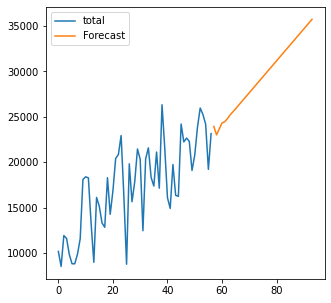

In [42]:
mod = SARIMAX(car_dummies['total'], order = (2,2,1))
res = mod.fit()

#forecast 3 years (to 2025)

forecast = res.predict(start = len(car_dummies), 
                          end = (len(car_dummies) + 3*12), 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
car_dummies['total'].plot(figsize = (5, 5), legend = True)
forecast.plot(legend = True)

### 3-4. Hyundai Car (pre-covid)

* parameter (1, 0, 0)

In [43]:
# Split data into train / test sets
train = car_precovid_dummies.iloc[:len(car_precovid_dummies)-12]
test = car_precovid_dummies.iloc[len(car_precovid_dummies)-12:] # set one year(12 months) for testing
  
model = SARIMAX(train['total'], 
                order = (1, 0, 0))
  
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   13
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -122.779
Date:                Tue, 20 Dec 2022   AIC                            249.558
Time:                        22:08:30   BIC                            250.687
Sample:                             0   HQIC                           249.325
                                 - 13                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9738      0.058     16.879      0.000       0.861       1.087
sigma2      7.547e+06   4.91e-10   1.54e+16      0.000    7.55e+06    7.55e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.85   Prob(JB):                         0.75
Heteroskedasticity (H):               3.34   Skew:                             0.39
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

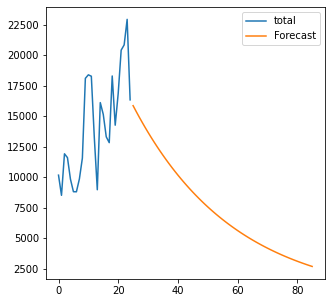

In [44]:
mod = SARIMAX(car_precovid_dummies['total'], order = (1,0,0))
res = mod.fit()

#forecast 5 years (to 2025)

forecast = res.predict(start = len(car_precovid_dummies), 
                          end = (len(car_precovid_dummies) + 5*12), 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
car_precovid_dummies['total'].plot(figsize = (5, 5), legend = True)
forecast.plot(legend = True)

* parameter (9, 0, 1)

In [45]:
# Split data into train / test sets
train = car_precovid_dummies.iloc[:len(car_precovid_dummies)-12]
test = car_precovid_dummies.iloc[len(car_precovid_dummies)-12:] # set one year(12 months) for testing
  
model = SARIMAX(train['total'], 
                order = (9, 0, 1))
  
result = model.fit()
result.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                   13
Model:               SARIMAX(9, 0, 1)   Log Likelihood               -6072.520
Date:                Tue, 20 Dec 2022   AIC                          12167.040
Time:                        22:08:32   BIC                          12173.255
Sample:                             0   HQIC                         12165.763
                                 - 13                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6475      0.000   3728.673      0.000       1.647       1.648
ar.L2         -0.3231      0.003   -120.574      0.000      -0.328      -0.318
ar.L3         -1.2955      0.003   -517.726      0.000      -1.300      -1.291
ar.L4          1.5908      0.005    298.306      0.000       1.580       1.601
ar.L5         -1.5904      0.005   -300.618      0.000      -1.601      -1.580
ar.L6          1.2918      0.002    549.733      0.000       1.287       1.296
ar.L7          0.3403      0.002    169.567      0.000       0.336       0.344
ar.L8         -1.6492      0.000  -4370.604      0.000      -1.650      -1.648
ar.L9          0.9878      0.000   1982.331      0.000       0.987       0.989
ma.L1          0.8147      0.088      9.252      0.000       0.642       0.987
sigma2        25.2944      1.515     16.692      0.000      22.324      28.264
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 4.16
Prob(Q):                              0.74   Prob(JB):                         0.12
Heteroskedasticity (H):             189.81   Skew:                            -1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.37e+14. Standard errors may be unstable.
"""

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



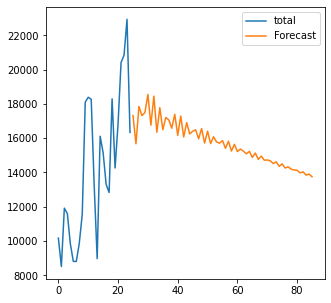

In [46]:
mod = SARIMAX(car_precovid_dummies['total'], order = (9,0,1))
res = mod.fit()

#forecast 5 years (to 2025)

forecast = res.predict(start = len(car_precovid_dummies), 
                          end = (len(car_precovid_dummies) + 5*12), 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
car_precovid_dummies['total'].plot(figsize = (5, 5), legend = True)
forecast.plot(legend = True)